In [1]:
# Enable plot ouputting in the notebook directly 
%matplotlib inline

from keras import applications, callbacks, layers, losses, metrics, Model, optimizers, utils
from PIL import Image
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf


# Data

## Basic Information of Data Set

In [2]:
# Load dataset 
data_dir = os.path.join( 'data' )
data_dir = pathlib.Path(data_dir).with_suffix( '' )

In [3]:
image_count = len( list( data_dir.glob( '*/*.jpg' ) ) )
print( image_count )

4752


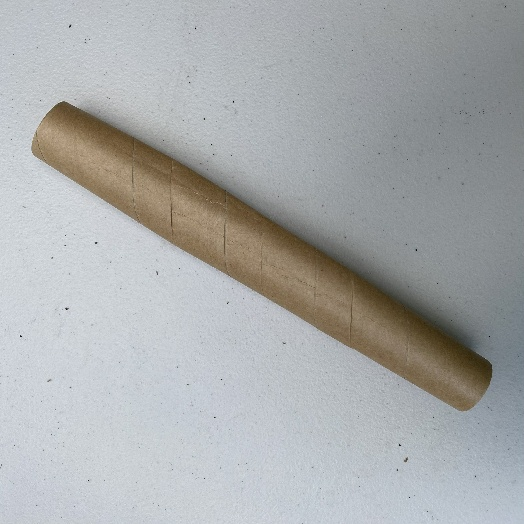

In [4]:
cardboard = list( data_dir.glob( 'Cardboard/*' ) )
Image.open( str( cardboard[ 0 ] ) )

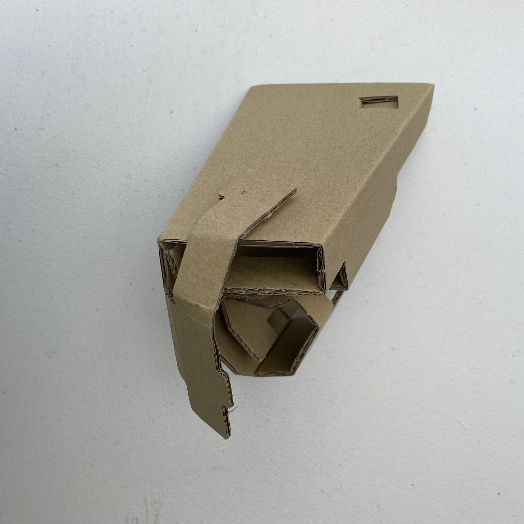

In [5]:
Image.open( str( cardboard[ 1 ] ) )

In [6]:
batch_size = 32
img_height = 224
img_width = 224

## Process Images

In [7]:
import splitfolders

splitfolders.ratio( data_dir, seed = 1337, output = "data_split", ratio = ( 0.8, 0.1, 0.1 ))

In [8]:
train_dir = os.path.join( 'data_split', 'train' )
train_dir = pathlib.Path(train_dir).with_suffix( '' )
train_count = len( list( train_dir.glob( '*/*.jpg' ) ) )

valid_dir = os.path.join( 'data_split', 'val' )
valid_dir = pathlib.Path(valid_dir).with_suffix( '' )
valid_count = len( list( valid_dir.glob( '*/*.jpg' ) ) )

test_dir = os.path.join( 'data_split', 'test' )
test_dir = pathlib.Path(test_dir).with_suffix( '' )
test_count = len( list( test_dir.glob( '*/*.jpg' ) ) )

print( f"Train: { train_count } - { valid_count } - { test_count }" )

Train: 3798 - 473 - 481


In [9]:
train_ds = utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3798 files belonging to 9 classes.


In [10]:
valid_ds = utils.image_dataset_from_directory(
  valid_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 473 files belonging to 9 classes.


In [11]:
class_names = train_ds.class_names
num_class = len( class_names )
print(num_class, class_names)

9 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


(32, 224, 224, 3)
(32,)


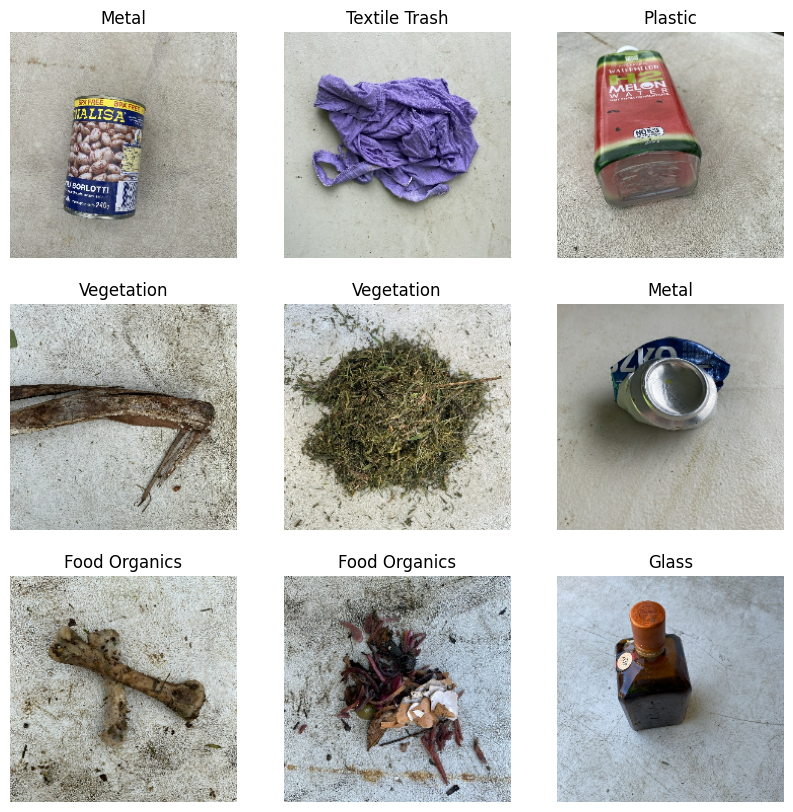

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling( 1 / 255.0 ) # Normalize the image to [0, 1]

In [15]:
normalized_ds = train_ds.map( lambda x, y: ( normalization_layer( x ), y ) ) 
image_batch, labels_batch = next( iter( normalized_ds ) )
first_image = image_batch[ 0 ]

print( np.min( first_image ), np.max( first_image ) ) 

0.052147333 0.9683877


# Model

In [16]:
def build_model():
    """ Inputs """
    inputs = layers.Input( ( img_height, img_width, 3 ) )

    """ Backbone """
    backbone = applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        alpha=1.0
    )
    backbone.trainable = True

    """ Detection Head """
    x = backbone.output

    x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    layers.Dropout(0.5)
    label = layers.Dense(num_class, activation="softmax", name="label")(x)

    """ Model """
    model = Model( inputs = [ inputs ], outputs = [ label ] )
    return model

In [17]:
model = build_model()

C:\Users\kevin\AppData\Local\Temp\ipykernel_31584\3086794246.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = applications.MobileNetV2(


In [18]:
# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Prints a message when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

In [19]:
model.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam( 1e-5 ),
    metrics = [ 'accuracy' ]
)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,723,145 (10.39 MB)

 Trainable params: 2,688,521 (10.26 MB)

 Non-trainable params: 34,624 (135.25 KB)

In [21]:
num_epochs = 50

history = model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data=valid_ds, 
        callbacks=[early_stopping]
        )

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.1885 - loss: 2.1649 - val_accuracy: 0.2008 - val_loss: 2.1252
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5632 - loss: 1.6730 - val_accuracy: 0.3510 - val_loss: 1.9388
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6943 - loss: 1.2778 - val_accuracy: 0.4228 - val_loss: 1.7945
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7633 - loss: 1.0094 - val_accuracy: 0.4672 - val_loss: 1.6547
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8082 - loss: 0.8112 - val_accuracy: 0.5180 - val_loss: 1.4751
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8537 - loss: 0.6553 - val_accuracy: 0.5581 - val_loss: 1.2890
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8899 - loss: 0.5315 - val_accuracy: 0.6216 - val_loss: 1.1320
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9179 - loss: 0.4495 - val_accu

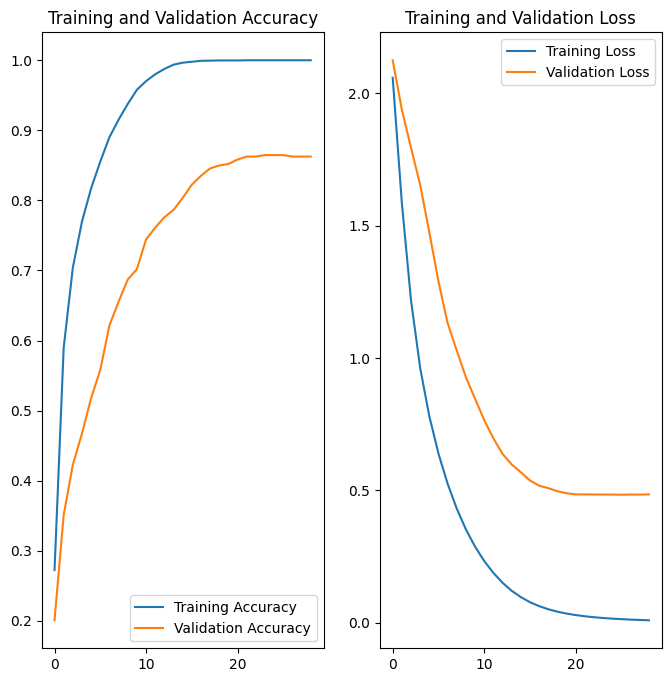

In [24]:
true_epoch = 29
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(true_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test with New Data

In [25]:
test_ds = utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 481 files belonging to 9 classes.


In [26]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8342 - loss: 0.5011
Test Loss: 0.49558040499687195
Test Accuracy: 0.837837815284729


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
0
Image 1:
Predicted Label: Metal
True Label: Metal
------------------------------
1
Image 2:
Predicted Label: Cardboard
True Label: Cardboard
------------------------------
2
Image 3:
Predicted Label: Paper
True Label: Paper
------------------------------
3
Image 4:
Predicted Label: Plastic
True Label: Plastic
------------------------------
4
Image 5:
Predicted Label: Glass
True Label: Glass
------------------------------
5
Image 6:
Predicted Label: Textile Trash
True Label: Textile Trash
------------------------------
6
Image 7:
Predicted Label: Metal
True Label: Metal
------------------------------
7
Image 8:
Predicted Label: Miscellaneous Trash
True Label: Miscellaneous Trash
------------------------------
8
Image 9:
Predicted Label: Cardboard
True Label: Cardboard
------------------------------


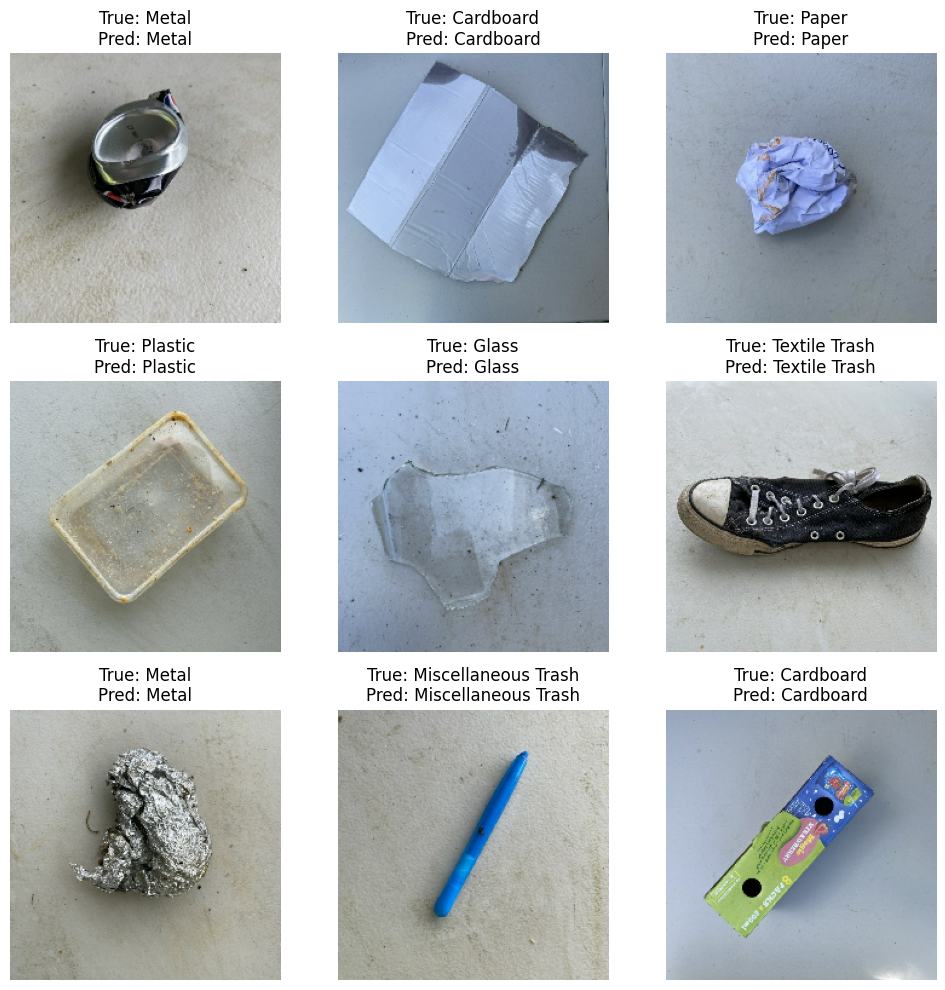

In [38]:
# Make predictions and visualize results on the test dataset
plt.figure(figsize=(10, 10))

for images, true_labels in test_ds.take(1): 
    predictions = model.predict(images)  
    predicted_classes = np.argmax(predictions, axis=1)  # Convert predictions to class indices

    # Convert indices to actual class labels (names)
    predicted_labels = [class_names[i] for i in predicted_classes]
    true_labels_names = [class_names[i] for i in true_labels.numpy()]  

    # Display and visualize results
    for i in range(len(predicted_labels)):
        if i > 8:
            break

        print(f"Image {i+1}:")
        print(f"Predicted Label: {predicted_labels[i]}")
        print(f"True Label: {true_labels_names[i]}")
        print("-" * 30)

        # Visualize the images with true and predicted labels
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(f"True: {true_labels_names[i]}\nPred: {predicted_labels[i]}") 
        plt.axis("off")

plt.tight_layout()
plt.show()

## Export Model

In [39]:
model.save("model.h5")

In [42]:
from keras import models

model_load = models.load_model("model.h5", compile=False)

In [43]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8342 - loss: 0.5011
Test Loss: 0.49558040499687195
Test Accuracy: 0.837837815284729
